#  BOSTON HOUSING PRICES

The given dataset has several parameters that contribute to the pricing of houses in Boston city, the motive is to work with the dataset and use a suitable model to predict housing prices in Boston

## Importing necessary libraries to work with

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

## Loading the dataset

In [2]:
data = pd.read_csv('boston.csv')

##  Viewing data structure and Identifying the Target variable (dependent variable)

In [3]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### `'MEDV'` is the Target Variable

## Identifying higly correlated variables

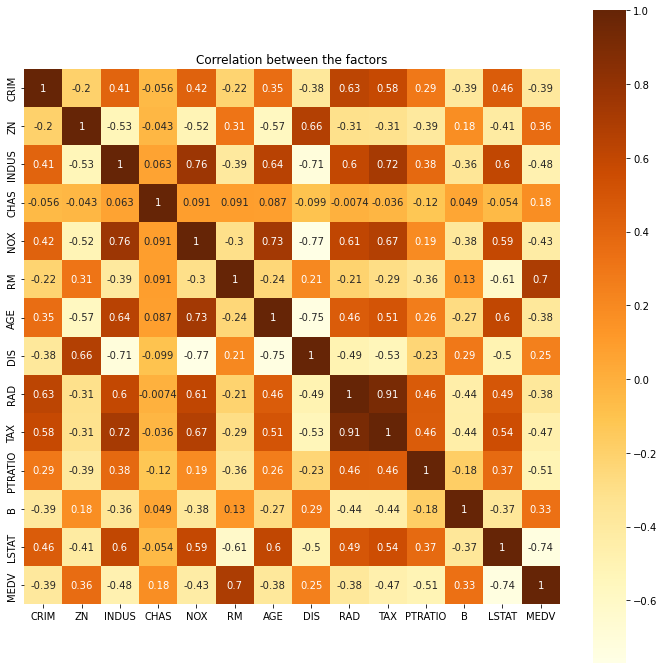

In [4]:
corr = data.corr()
plt.figure(figsize = (12,12))
sb.heatmap(corr, square=True, annot=True, cmap="YlOrBr").set_title('Correlation between the factors')
plt.show()

### The following pairs of variables are highly correlated (r > 0.7) :
* INDUS & NOX
* INDUS & TAX
* NOX & AGE
* INDUS & DIS
* NOX & DIS
* AGE & DIS
* RAD & TAX

### choose  `'NOX'`, `'TAX'`
### drop `'INDUS'`, `'AGE'`, `'DIS'`, `'RAD'`

## Eliminating strongly correlated variable pairs

In [5]:
new_data = data.drop(['INDUS', 'AGE', 'DIS', 'RAD'], axis='columns')
new_data.head()

,CRIM,ZN,CHAS,NOX,RM,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,0,0.538,6.575,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,0,0.469,6.421,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,0,0.469,7.185,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,0,0.458,6.998,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,0,0.458,7.147,222.0,18.7,396.90,5.33,36.2


## One Hot Encoding the categorical variables

In [6]:
categorical_variables = ['CHAS']

In [7]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
catvar = ohe.fit_transform(new_data[categorical_variables]).toarray()

## Normalizing the Dataset

In [8]:
continuous_variables = ['CRIM', 'ZN', 'NOX', 'RM', 'TAX', 'PTRATIO', 'B', 'LSTAT']

In [9]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(new_data[continuous_variables])
scaled_data=scaler.transform(new_data[continuous_variables])

## Forming a matrix array of feature variables (continuous and categorical)

In [10]:
matrix = np.concatenate((scaled_data, catvar), axis=1)

## Using PCA for feature variables

In [11]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(matrix)
x_pca=pca.transform(matrix)

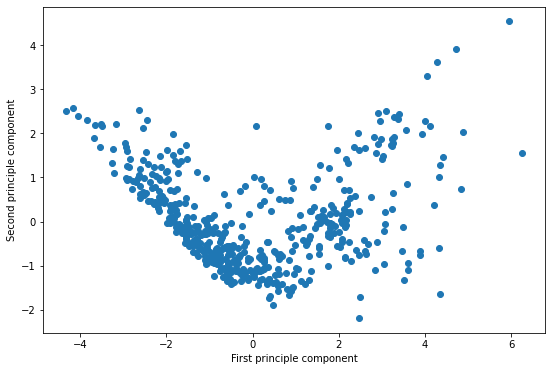

In [12]:
plt.figure(figsize=(9,6))
plt.scatter(x_pca[:,0],x_pca[:,1])
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.show()

### Close to a `quadratic` graph
### We try polynomial regression (degree=2) and random forest regression models and choose the one that gives better results (Lower RMSE)

## Splitting dataset into test and train data (80:20)

In [13]:
x = matrix
y = new_data.iloc[:,-1]

In [14]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.20)

## Training using polynomial regression (degree=2) 

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

poly = PolynomialFeatures(degree=2)
poly.fit(x_train, y_train)

model=LinearRegression()
model.fit(poly.fit_transform(x_train),y_train)
pred_train=model.predict(poly.fit_transform(x_train))
pred_test=model.predict(poly.fit_transform(x_test))

## Results (RMSE) for polynomial regression model 

In [16]:
print('RMSE in training dataset :', np.sqrt(mean_squared_error(y_train, pred_train)))
print('RMSE in testing dataset :', np.sqrt(mean_squared_error(y_test, pred_test)))

RMSE in training dataset : 3.08695558175761
RMSE in testing dataset : 3.1421914734033582


## Training using Random Forest Regressor

In [17]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(x_train, y_train) 
pred_train = regressor.predict(x_train)
pred_test = regressor.predict(x_test)

## Results (RMSE) for Random Forest Regressor Model 

In [18]:
print('RMSE in training dataset :', np.sqrt(mean_squared_error(y_train, pred_train)))
print('RMSE in testing dataset :', np.sqrt(mean_squared_error(y_test, pred_test)))

RMSE in training dataset : 1.4796403931595354
RMSE in testing dataset : 2.6607148051810805


### RandomForestRegressor model gives better results

## Using GridSearch to find the best set of hyperparameters

In [19]:
n_estimators = [x for x in range(0,100,5)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [2,4,6]
min_samples_split = [1,2]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

In [20]:
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

In [21]:
rf_Model = RandomForestRegressor()

In [22]:
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
rf_Grid.fit(x_train, y_train)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


C:\Users\srama\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.82826074 0.83170791 0.82873273]
  warnings.warn(


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [1, 2],
                         'n_estimators': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45,
                                          50, 55, 60, 65, 70, 75, 80, 85, 90,
                                          95]},
             verbose=2)

## Best Hyper-Parameters

In [23]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 70}

## Fitting the best Hyper-Parameters in Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=65, max_depth=6, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, bootstrap=False)
regressor.fit(x_train, y_train) 
pred_train = regressor.predict(x_train)
pred_test = regressor.predict(x_test)

## Results(RMSE)

In [25]:
print('RMSE in training dataset :', np.sqrt(mean_squared_error(y_train, pred_train)))
print('RMSE in testing dataset :', np.sqrt(mean_squared_error(y_test, pred_test)))

RMSE in training dataset : 1.9048478028217015
RMSE in testing dataset : 2.5733518833749818


In [26]:
print ('Train Accuracy - :', rf_Grid.score(x_train,y_train))
print ('Test Accuracy - :',rf_Grid.score(x_test,y_test))

Train Accuracy - : 0.9583218951343581
Test Accuracy - : 0.9020288430918777


# END